XGB

In [1251]:
# modules we'll use
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

import xgboost as xgb

from sklearn.model_selection import train_test_split
# set seed for reproducibility
np.random.seed(0)

In [1252]:
traindata = pd.read_csv("./Male_Female.csv")

In [1253]:
traindata.head()

,Favorite Color,Favorite Music Genre,Favorite Beverage,Favorite Soft Drink,Gender
0,Cool,Rock,Vodka,7UP/Sprite,F
1,Neutral,Hip hop,Vodka,Coca Cola/Pepsi,F
2,Warm,Rock,Wine,Coca Cola/Pepsi,F
3,Warm,Folk/Traditional,Whiskey,Fanta,F
4,Cool,Rock,Vodka,Coca Cola/Pepsi,F


In [1254]:
#Find missing values:

missing_values_count = traindata.isnull().sum()
total_cells = np.product(traindata.shape)
total_missing = missing_values_count.sum()
percent_missing = (total_missing/total_cells) * 100
percent_missing

0.0

In [1255]:
y = traindata['Gender']
X = traindata.drop(['Gender'], axis = 1)

In [1256]:
# Categorical columns in the training data
X_object_cols = [col for col in X.columns if X[col].dtype == "object"]
X_object_cols

['Favorite Color',
 'Favorite Music Genre',
 'Favorite Beverage',
 'Favorite Soft Drink']

In [1257]:
y = traindata['Gender']
y = y.map({ 'M' : 1, 'F' : 0})

In [1258]:
###NB! It must be done for the use of enable_categorical=True in XGBoost
X["Favorite Color"] = X["Favorite Color"].astype("category")
X["Favorite Music Genre"] = X["Favorite Music Genre"].astype("category")
X["Favorite Beverage"] = X["Favorite Beverage"].astype("category")
X["Favorite Soft Drink"] = X["Favorite Soft Drink"].astype("category")

In [1259]:
X.dtypes

Favorite Color          category
Favorite Music Genre    category
Favorite Beverage       category
Favorite Soft Drink     category
dtype: object

In [1260]:
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)

In [1261]:
params = {'objective' : 'binary:hinge',
         'eval_metric': 'auc'}

#I used binary:logistic. But when I predict only one valus - it gave me alwayas 0. Why??? After using 'binary:hinge' the result became better, but when I use only one X, I receive only 1:))))

clf = xgb.XGBClassifier(**params, tree_method="hist", enable_categorical=True, feature_types="c")
# X is the dataframe we created in previous snippet
clf.fit(X_train, y_train)
# Must use JSON/UBJSON for serialization, otherwise the information is lost.
clf.save_model("Male_Female_Model.json")

In [1262]:
clf.feature_importances_

array([0.256812  , 0.28792527, 0.24240002, 0.21286264], dtype=float32)

In [1263]:
model_acc = clf.score(X_train, y_train)
model_acc

#low score because of scale_pos_weight

0.9615384615384616

In [1264]:
scores = -1 * cross_val_score(clf, X, y, cv=5, scoring='accuracy')
scores.mean()

-0.6230769230769231

In [1265]:
clf.scale_pos_weight

<Axes: >

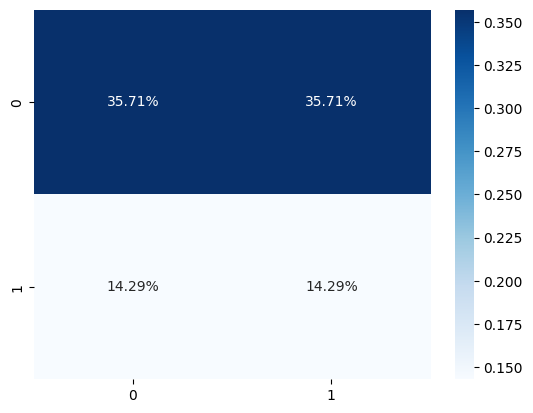

In [1266]:
preds = clf.predict(X_val)
cf_matrix = confusion_matrix(preds, y_val)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, cmap='Blues', fmt='.2%')

In [1267]:
testdata = pd.read_csv("./MLTest.csv")
testdata["Favorite Color"] = testdata["Favorite Color"].astype("category")
testdata["Favorite Music Genre"] = testdata["Favorite Music Genre"].astype("category")
testdata["Favorite Beverage"] = testdata["Favorite Beverage"].astype("category")
testdata["Favorite Soft Drink"] = testdata["Favorite Soft Drink"].astype("category")

In [1268]:
testdata

,Favorite Color,Favorite Music Genre,Favorite Beverage,Favorite Soft Drink
0,Warm,Rock,Wine,Coca Cola/Pepsi


In [1269]:
ypred = clf.predict(testdata)

In [1270]:
# Not correct!

ypred

array([0])

In [1271]:
# Concatinate with validation data, with big amount of features. Check the last N.

t0 = pd.DataFrame()
t0 = pd.concat([X_val, testdata], ignore_index=True)

t0["Favorite Color"] = t0["Favorite Color"].astype("category")
t0["Favorite Music Genre"] = t0["Favorite Music Genre"].astype("category")
t0["Favorite Beverage"] = t0["Favorite Beverage"].astype("category")
t0["Favorite Soft Drink"] = t0["Favorite Soft Drink"].astype("category")

In [1272]:
t0

,Favorite Color,Favorite Music Genre,Favorite Beverage,Favorite Soft Drink
0,Cool,Electronic,Doesn't drink,Fanta
1,Cool,Hip hop,Beer,Coca Cola/Pepsi
2,Cool,Rock,Vodka,7UP/Sprite
3,Cool,Hip hop,Beer,Coca Cola/Pepsi
4,Warm,Jazz/Blues,Doesn't drink,Fanta
5,Neutral,Hip hop,Doesn't drink,Fanta
6,Cool,Pop,Wine,7UP/Sprite
7,Warm,Pop,Wine,7UP/Sprite
8,Cool,Electronic,Beer,Coca Cola/Pepsi
9,Warm,Rock,Other,Coca Cola/Pepsi


In [1273]:
result = clf.predict(t0)

In [1274]:
result

# Here I see zero, when I add my data to training dataset, that have at least one data row. If there is no row - I recieve not correct info. When the same rows, 
# I recieve 1 (incorrect info). !!!If I change data in testdata (example: Warm,R&B and soul,Wine,Other), I receive other data in result. If I have (Cool,Electronic,Other,Fanta)
# - it's ok. How?:)))
# For solving it I use concatination with X_val. Get betterresult.


array([0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0])

In [1275]:
result[-len(ypred):]

array([0])

In [1276]:
# Pred not from file:

F1 = "Warm"
F2 = "Electronic"
F3 = "Wine"
F4 = "Coca Cola/Pepsi"

t1 = pd.DataFrame({"Favorite Color": [F1], "Favorite Music Genre": [F2], "Favorite Beverage": [F3], "Favorite Soft Drink": [F4]})

#t1 = pd.DataFrame(np.array([[F1, F2, F3, F4]]), columns=['Favorite Color', 'Favorite Music Genre', 'Favorite Beverage', 'Favorite Soft Drink'])

t1["Favorite Color"] = t1["Favorite Color"].astype("category")
t1["Favorite Music Genre"] = t1["Favorite Music Genre"].astype("category")
t1["Favorite Beverage"] = t1["Favorite Beverage"].astype("category")
t1["Favorite Soft Drink"] = t1["Favorite Soft Drink"].astype("category")